# PV data from the IPE battery container

This script should collect the pv generation data from the IPE PV plant. Avaliable measurements are: current, voltage, power, etc.
- **Relevant measurement: Power** 

In [1]:
#!pip install influxdb
#!pip install matplotlib

from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

In [2]:
# Configuration parameters
host = '141.52.65.125'
port = 8086
dbname = 'iobroker'
user = 'admin'
password = 'Karlsruhe23!'

# Input for time interval
start_datetime = datetime.strptime("2024-03-01 00:00:00", '%Y-%m-%d %H:%M:%S')
end_datetime = datetime.strptime("2024-03-21 23:59:59", '%Y-%m-%d %H:%M:%S')

# Adjust the query to dynamically use the calculated interval
query = f'SELECT MEAN("value") AS mean_value FROM "modbus.0.inputRegisters.30775_AC_Wirkleistung" ' \
        f'WHERE time >= \'{start_datetime.strftime("%Y-%m-%d %H:%M:%S")}\' AND time <= \'{end_datetime.strftime("%Y-%m-%d %H:%M:%S")}\' ' \
        f'GROUP BY time(30m) fill(null)'

#Fetch data
client = InfluxDBClient(host, port, user, password, dbname)
result = client.query(query)
times = []
active_power_values = []
for point in result.get_points():
    times.append(datetime.strptime(point['time'], '%Y-%m-%dT%H:%M:%SZ'))
    active_power_values.append(point['mean_value'])

# Close the client
client.close()

In [6]:
#Data preprocessing -> None, Null, negative values -> 0

# Filter out None and NaN values and ensure positive values
active_power_cleaned_values = [x if x is not None and x >= 0 else 0 for x in active_power_values]
# Convert to NumPy array for further calculations
active_power_cleaned_values = np.array(active_power_cleaned_values)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


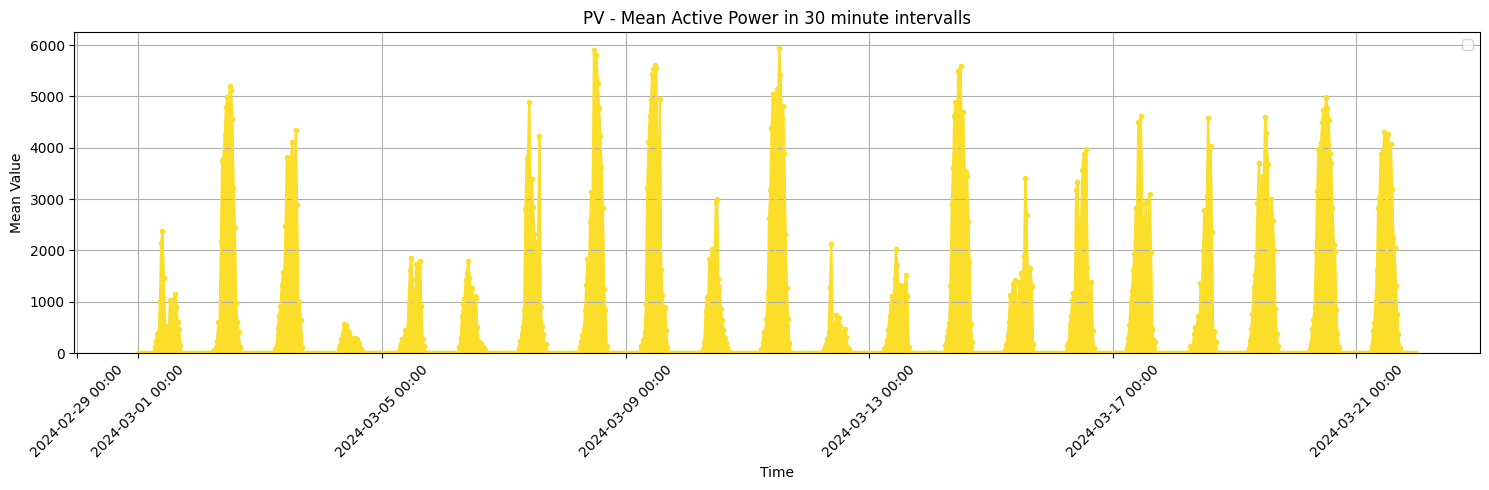

In [7]:
# Plotting
plt.figure(figsize=(15, 5))

# Use fill_between for filling under the line, with a strong yellow color
plt.plot(times, active_power_cleaned_values, marker='o', linestyle='-', markersize=3, color='#fade2a')
plt.fill_between(times, active_power_cleaned_values, color='#fade2a')

plt.title(f'PV - Mean Active Power in 30 minute intervalls')
plt.xlabel('Time')
plt.ylabel('Mean Value')

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Set up the date formatter for the x-axis
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()